# Comparing rust-fc To Simulation Output

In [1]:
from psas_packet.io import BinFile
import csv

FPS2M = 0.3048

# Read data from rust-fc
logfile = BinFile('../logfile-000')
rust_accel_x = []
for fourcc, data in logfile.read():
    if fourcc == 'ADIS':
        rust_accel_x.append(data['Acc_X'])


# Read data from JSBSim
sim_accel_x = []
with open('../simulation/data.csv') as datafile:
    reader = csv.reader(datafile, delimiter=',')
    for row in reader:
        # ignore first line
        if row[0][0] == 'T':
            continue
        sim_accel_x.append(float(row[12])*FPS2M)

boundary?


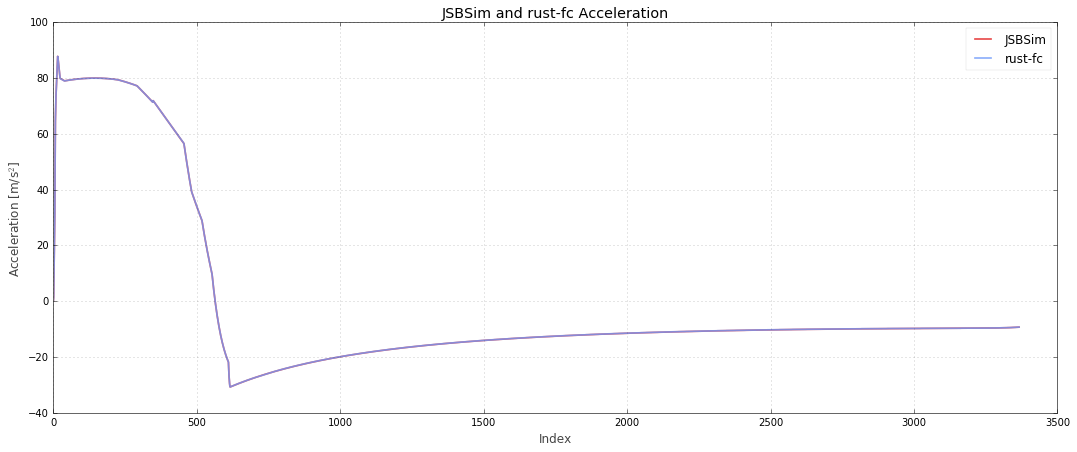

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots(figsize=(18,7))
plt.title(r"JSBSim and rust-fc Acceleration")
plt.ylabel(r"Acceleration [m/s${}^2$]")
plt.xlabel(r"Index")

plt.plot(range(len(sim_accel_x)), sim_accel_x, alpha=0.8, label="JSBSim")
plt.plot(range(len(rust_accel_x)), rust_accel_x, alpha=0.8, label="rust-fc")

#plt.ylim()
#plt.xlim()
ax1.legend(loc=1,)
plt.show()